In [73]:
import numpy as np
#import tensorflow as tf
#from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.model_selection import cross_val_score

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42


In [127]:
data=pd.read_csv('dataCompletAvrilto18Juin.csv', sep=";", encoding = "ISO-8859-1")
data1=pd.read_csv('kalmanArima_TRUE_MCAR5.csv', sep=",", encoding = "ISO-8859-1")

#Linky=pd.read_csv('Enedis_Conso_Heure_20210325-20210427_09311432680380.csv', sep=";", encoding = "ISO-8859-1")

In [128]:
data1["activity"]=data.activity

In [129]:
data = data1.copy()

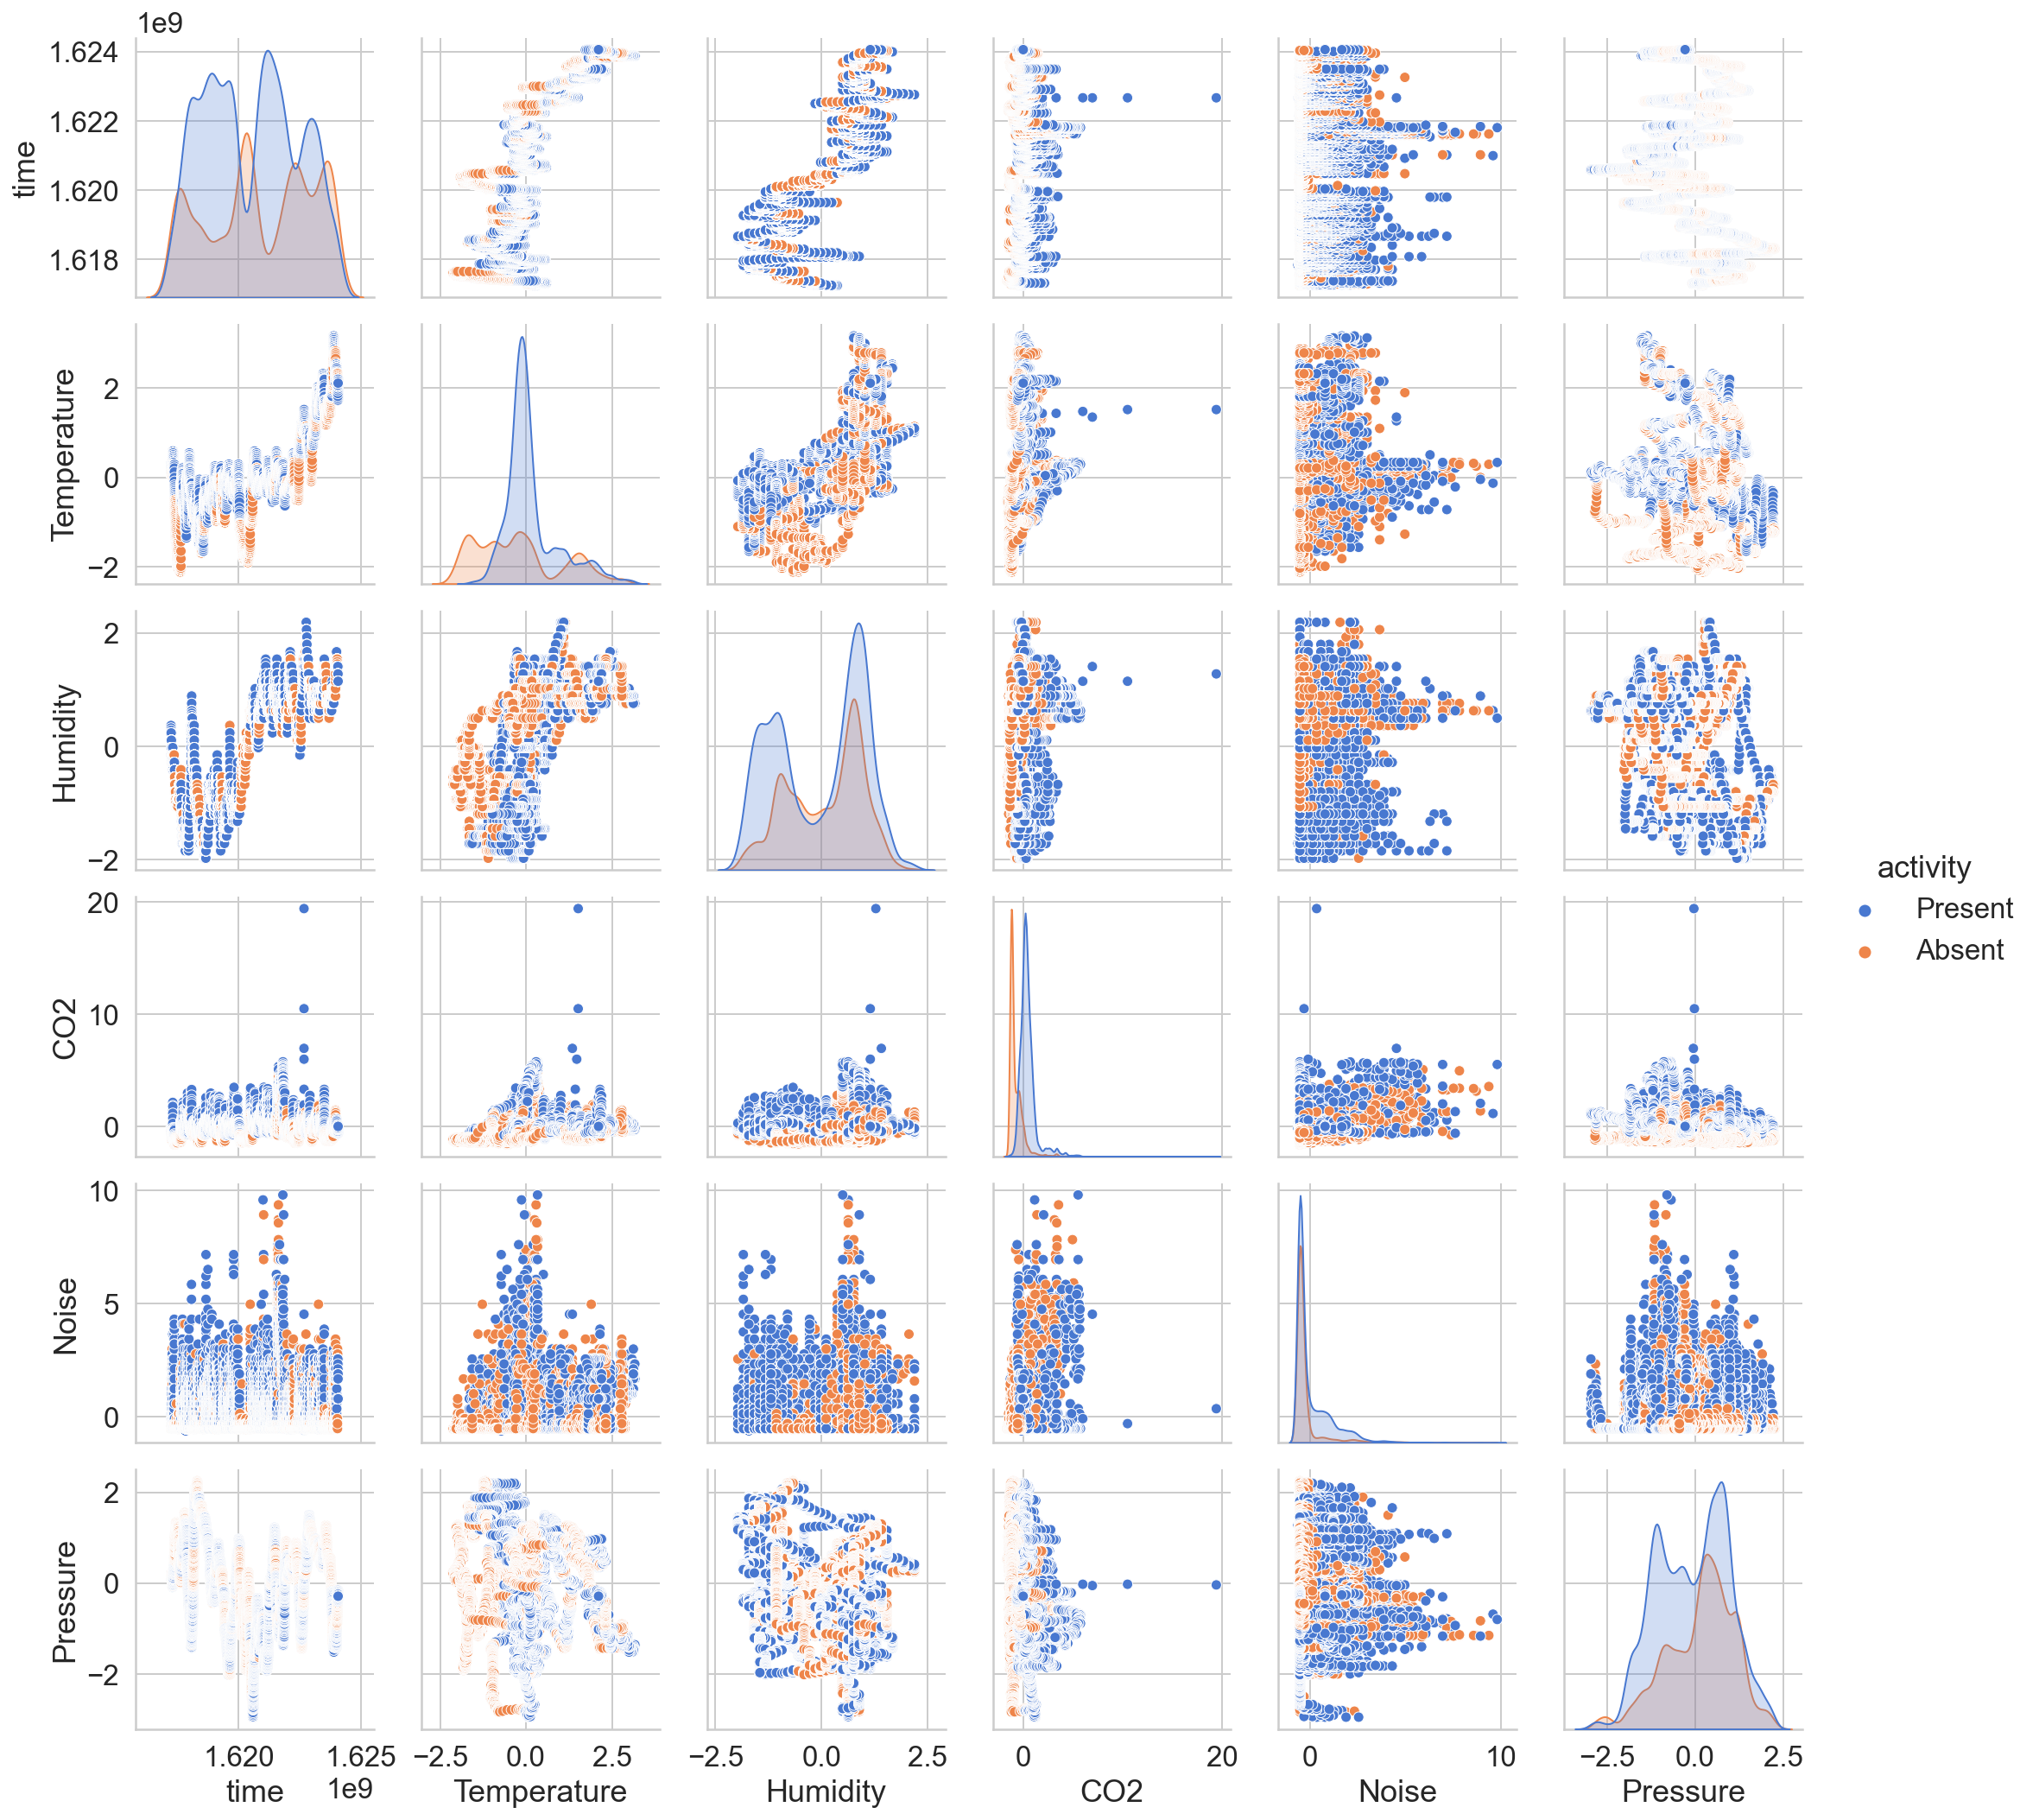

In [130]:
sns.pairplot(data,  hue='activity')

In [131]:
data.activity.unique()
data['activity'].replace(['Absent','Present'],[0,1], inplace=True)

In [132]:
db2=data.copy()
X=db2.drop('time', axis=1).copy()
X=X.drop('activity', axis=1)
y=db2['activity']
from collections import Counter

counter = Counter(y)
for k, v in counter.items():
    dist = v / len(y) * 100
    print(f"Class={k}, n={v} ({dist}%)")

Class=1, n=14185 (62.98006482262576%)
Class=0, n=8338 (37.01993517737424%)


In [133]:
# partitionnement des données en train & test 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

# RandomForestClassifier

In [134]:
# importation de la bibiothèque RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
# construire un model random forest
# Instanciation du modèle
rf_model=RandomForestClassifier(max_features='log2', n_estimators= 300, max_depth=500, criterion='entropy') 
# entrainement du model
rf_model.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=500, max_features='log2',
                       n_estimators=300)

In [135]:
# afficher le score du modele sur les données d'entrainement
rf_model.score(X_train,y_train)

0.9996194342255487

In [136]:
# afficher le score du modele sur les données de test
rf_model.score(X_test,y_test)

0.9757288737605446

In [137]:
# afficher l’importance des variables de notre modèle de forêt aléatoire
pd.DataFrame(rf_model.feature_importances_,
              index = X_train.columns, 
              columns = ["importance"]).sort_values(
     "importance", 
     ascending = False)

,importance
CO2,0.507727
Temperature,0.189898
Pressure,0.130526
Humidity,0.102656
Noise,0.069192


# Matrice de confusion

In [138]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, rf_model.predict(X_test)),
             index = ["Present_data", "Abscent_data"],
             columns = ["Present_predit", "Abscent_predit"])

,Present_predit,Abscent_predit
Present_data,2335,123
Abscent_data,41,4258


In [139]:
from sklearn import metrics

y_pred = rf_model.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.98274411, 0.97192422]),
 array([0.94995932, 0.9904629 ]),
 array([0.96607365, 0.98110599]),
 array([2458, 4299], dtype=int64))

In [140]:
#db2['Activity_Pred']=model.predict(X)

# AdaBoostClassifier

In [141]:
from sklearn.ensemble import AdaBoostClassifier
clf_AdaBoost = AdaBoostClassifier(n_estimators=200, random_state=42)
clf_AdaBoost.fit(X_train, y_train)
clf_AdaBoost.score(X_test, y_test)

0.9042474470919047

In [142]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, clf_AdaBoost.predict(X_test)),
             index = ["Present_data", "Abscent_data"],
             columns = ["Present_predit", "Abscent_predit"])

,Present_predit,Abscent_predit
Present_data,2017,441
Abscent_data,206,4093


In [143]:
from sklearn import metrics
y_pred = clf_AdaBoost.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.90733243, 0.90273489]),
 array([0.82058584, 0.95208188]),
 array([0.86178167, 0.92675195]),
 array([2458, 4299], dtype=int64))

# DecisionTreeClassifier

In [144]:
from sklearn.tree import DecisionTreeClassifier
#clf_tree = DecisionTreeClassifier(max_depth=4, criterion='gini')
clf_tree= DecisionTreeClassifier(max_features='log2', max_depth=500, criterion='entropy')
clf_tree.fit(X_train, y_train)
y_pred = clf_tree.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9591534704750629

In [145]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, clf_tree.predict(X_test)),
             index = ["Present_data", "Abscent_data"],
             columns = ["Present_predit", "Abscent_predit"])

,Present_predit,Abscent_predit
Present_data,2314,144
Abscent_data,132,4167


In [146]:
from sklearn import metrics

y_pred = clf_tree.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.94603434, 0.96659708]),
 array([0.94141579, 0.96929518]),
 array([0.94371941, 0.96794425]),
 array([2458, 4299], dtype=int64))

In [147]:
## SVM

In [148]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svc_model = make_pipeline(StandardScaler(), SVC(C=10, gamma=1))
svc_model.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma=1))])

In [149]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc=scaler.fit_transform(X_train)

In [150]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, svc_model.predict(X_test)),
             index = ["Present_data", "Abscent_data"],
             columns = ["Present_predit", "Abscent_predit"])

,Present_predit,Abscent_predit
Present_data,2253,205
Abscent_data,113,4186


In [151]:
from sklearn import metrics

y_pred = svc_model.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.95224007, 0.9533136 ]),
 array([0.91659886, 0.97371482]),
 array([0.9340796 , 0.96340621]),
 array([2458, 4299], dtype=int64))

# KNN

In [152]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model=KNeighborsClassifier(n_neighbors=1,metric='manhattan')
KNN_model.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [153]:
KNN_model.score(X_test,y_test)

0.9711410389225987

In [154]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, KNN_model.predict(X_test)),
             index = ["Present_data", "Abscent_data"],
             columns = ["Present_predit", "Abscent_predit"])

,Present_predit,Abscent_predit
Present_data,2350,108
Abscent_data,87,4212


In [155]:
from sklearn import metrics

y_pred = KNN_model.predict(X_test)
y_true = y_test
metrics.precision_recall_fscore_support(y_true, y_pred, beta=1)

(array([0.96430037, 0.975     ]),
 array([0.95606184, 0.97976274]),
 array([0.96016343, 0.97737557]),
 array([2458, 4299], dtype=int64))